In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import h5py
import os
import sys
import datetime
import csv

import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import logging
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

# For visualize input
from torch.utils.tensorboard import SummaryWriter
import io
import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from PIL import Image

class EEGDataset(Dataset):
    '''
    Custom Dataset object for PyTorch to load the dataset
    '''
    def __init__(self, x, y, train, val):
        super(EEGDataset).__init__()
        assert x.shape[0] == y.size
        self.x = x
        self.y = [y[i][0] for i in range(y.size)]
        self.train = train
        self.val = val

    def __getitem__(self,key):
        return (self.x[key], self.y[key])

    def __len__(self):
        return len(self.y)

class Logger():
    '''
    Object controlling how information will be logged
    A logger created globally will be used to log all information
    Create a Logger(mode='debug') to have everything print to the console
    '''
    def __init__(self, mode='log'):
        self.mode = mode
        
    def set_model_save_location(self, model_dir):
        self.model_dir = f"saved-model/{model_dir}"
        if not os.path.isdir(self.model_dir):
            os.mkdir(self.model_dir)
        
    def set_experiment(self, experiment_name):
        self.experiment_name = experiment_name
        log_format = '%(asctime)s %(message)s'
        logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                            format=log_format, datefmt='%m/%d %I:%M:%S %p')
        fh = logging.FileHandler(os.path.join('training-logs', f'log-{experiment_name}-{datetime.datetime.today()}.txt'))
        fh.setFormatter(logging.Formatter(log_format))
        logging.getLogger().addHandler(fh)
        self.writer = SummaryWriter(f"runs/{experiment_name}")
            
    def log(self, message=""):
        if self.mode == 'log':
            logging.info(message)
        elif self.mode == 'debug':
            print(message)

    def save_model(self, model, info):
        torch.save(model.state_dict(), f"{self.model_dir}/model-{logger.experiment_name}-{info}")
        
def load_data(path, role, winLength, numChan, srate, feature, one_channel=False, version=""):
    """
    Load dataset
    :param  
        path: Filepath to the dataset
        role: Role of the dataset. Can be "train", "val", or "test"
        winLength: Length of time window. Can be 2 or 15
        numChan: Number of channels. Can be 24 or 128
        srate: Sampling rate. Supporting 126Hz
        feature: Input feature. Can be "raw", "spectral", or "topo"
        one_channel: Whether input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
        version: Any additional information of the datafile. Will be appended to the file name at the end
    """
    transform = T.Compose([
        T.ToTensor()
    ])
    if version:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    x = f[f'X_{role}']
    if feature == 'raw':
        x = np.transpose(x,(0,2,1))
        x = np.reshape(x,(-1,1,numChan,winLength*srate))
    elif feature == 'topo':
        if one_channel:
            samples = []
            for i in range(x.shape[0]):
                image = x[i]
                b, g, r = image[0,:, :], image[1,:, :], image[2,:, :]
                concat = np.concatenate((b,g,r), axis=1)
                samples.append(concat)
            x = np.stack(samples)
            x = np.reshape(x,(-1,1,x.shape[1],x.shape[2]))
    
    if version:
        f = h5py.File(path + f"child_mind_yclass1_ages_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_yclass1_ages_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    y = np.subtract(f[f'Y_cls_{role}'], 1)
   
    return x,y



def plot_to_image_tensor(figure):
    # Save the plot to a PNG in memory.
    figure.savefig('batch.png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    img = Image.open('batch.png')
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    image_tensor = trans1(img)
    return image_tensor

def plot_EEG(data, feature, numChan, one_channel=True):
    '''
    Plot EEG sample
    :param
        data: An EEGDataset object
        feature: String - 'raw' or 'topo'
        numChan: Int - number of EEG channels
        one_channel: Bool - Whether input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
    '''
    x_data = data[:][0]
    if feature == 'raw':        
        fig = plt.figure(figsize=(80, 80))
        outer = gridspec.GridSpec(8, 8)
        for i in range(64):
            inner = gridspec.GridSpecFromSubplotSpec(numChan, 1,
                            subplot_spec=outer[i])
#             npimg = img[i,:,:,:].numpy()
            npimg = x_data[i,:,:,:]
            npimg = np.reshape(npimg,(24,256))
            yax = None
            for j in range(24):
                ax = plt.Subplot(fig, inner[j])
                ax.plot(range(256),npimg[j,:],'k')
                ax.set_xticks([])
                ax.set_yticks([])
                fig.add_subplot(ax)

        return fig
    else:
        sample = 2
        if one_channel:
            image = np.reshape(x_data[sample], (x_data[sample].shape[1],x_data[sample].shape[2]))
            plt.imshow(image.astype('int32'))
        else:
            plt.imshow(np.transpose(x_data[sample].astype('int32'), (1, 2, 0)))
        plt.show()

In [14]:
# Load EEG data
path = './data/'
winLength = 2
numChan = 24
srate = 128
feature = 'raw'
one_channel = False

role = 'train'
train_data_x, train_data_labels = load_data(path, role, winLength, numChan, srate, feature, one_channel)
# print(f'X_train shape: {len(train_data)}, {train_data[0][0].shape}')
# print(f'Y_train shape: {len(train_data)}, {train_data[0][1].shape}')

role = 'val'
val_data_x, val_data_labels = load_data(path, role, winLength, numChan, srate, feature, one_channel)
# print(f'X_val shape: {len(val_data)}, {val_data[0][0].shape}')
# print(f'Y_val shape: {len(val_data)}, {val_data[0][1].shape}')
# EEGDataset(x, y, role=='train', role=='val')
# plot_EEG(train_data, feature, numChan, one_channel)

In [18]:
train_data_y = train_data_labels.copy()
train_data_y[np.logical_and(train_data_labels <= 2,train_data_labels >= 0)] = 0
train_data_y[train_data_labels > 2] = 1
val_data_y = val_data_labels.copy()
val_data_y[np.logical_and(val_data_labels <= 2,val_data_labels >= 0)] = 0
val_data_y[val_data_labels > 2] = 1

(array([43597.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 27784.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

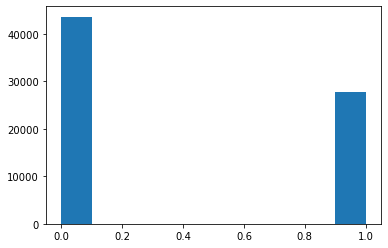

In [4]:
plt.hist(train_data_y)

In [59]:
43597/(43597+27784)

0.610764769336378

(array([24980.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 14888.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

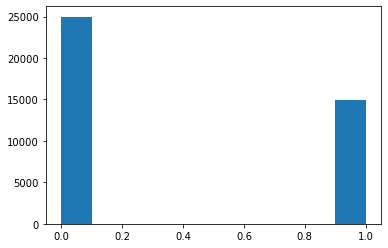

In [57]:
plt.hist(val_data_y)

In [61]:
24980/(24980+14888)

0.6265676733219625

In [58]:
train_data = EEGDataset(train_data_x, train_data_y, True, False)
val_data = EEGDataset(val_data_x, val_data_y, False, True)

In [106]:
train_data_x = train_data_x.reshape((71381, 24, 256))
val_data_x = val_data_x.reshape((39868, 24, 256))

In [99]:
train_data.shape()

AttributeError: 'EEGDataset' object has no attribute 'shape'

In [5]:
import tensorflow as tf
print(f"tf version={tf.__version__}")
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils
from tensorflow.keras import backend as K

tf version=1.14.0


In [6]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(24, 256)))
model.add(MaxPooling1D(2, 2, padding='same'))
model.add((Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')))
model.add(MaxPooling1D(2, 2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add((Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')))
model.add(MaxPooling1D(2, 2, padding='same'))
model.add((Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')))
model.add(MaxPooling1D(2, 2, padding='same'))
model.add(BatchNormalization())
model.add((Dropout(0.3)))

model.add(LSTM(256))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 64)            49216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 64)             256       
_________________________________________________________________
dropout (Dropout)            (None, 6, 64)             0         
____

In [13]:
model.fit(train_data_x, train_data_y, batch_size=64, epochs=50, validation_data=(val_data_x, val_data_y), shuffle=True)

Train on 71381 samples, validate on 39868 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
71381/71381 [==============================] - 43s 605us/sample - loss: 9.8387 - acc: 0.3893 - val_loss: 10.0991 - val_acc: 0.3734
Epoch 2/50
71381/71381 [==============================] - 42s 588us/sample - loss: 9.8444 - acc: 0.3892 - val_loss: 10.0991 - val_acc: 0.3734
Epoch 3/50
28480/71381 [==========>...................] - ETA: 21s - loss: 9.8780 - acc: 0.3871

KeyboardInterrupt: 

In [149]:
val_pred = model.predict(val_data_x)

In [151]:
val_pred = [p[0]<p[1] for p in val_pred]

In [152]:
val_pred[:5]

[False, False, False, False, False]

In [12]:
train_data_x = np.swapaxes(train_data_x, 1, 3)
train_data_x = np.swapaxes(train_data_x, 1, 2)
train_data_x.shape

(71381, 24, 256, 1)

In [8]:
val_data_x = np.swapaxes(val_data_x, 1, 3)
val_data_x = np.swapaxes(val_data_x, 1, 2)

In [9]:
train_data_y = tf.keras.utils.to_categorical(train_data_y)
val_data_y = tf.keras.utils.to_categorical(val_data_y)

In [10]:
model = Sequential()
model.add(Conv2D(100, 3, activation='relu', input_shape=(24, 256, 1)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(100, 3, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(300, (2, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(300, (1, 7), activation='relu'))
model.add(MaxPooling2D((1, 2), 1))
model.add(Dropout(0.25))
model.add(Conv2D(100, (1, 3), activation='relu'))
model.add(Conv2D(100, (1, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(6144, activation="relu"))
model.add(Dense(2, activation="relu"))

adam = keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 254, 100)      1000      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 127, 100)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 11, 127, 100)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 125, 100)       90100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 62, 100)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 62, 100)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 60, 300)       

In [20]:
!pip install pytorch-model-summary

In [64]:
# Create and show model summary
model = create_model()
#from pytorch_model_summary import summary
#print(summary(model, torch.zeros((1, 1, 24, 256)), show_input=False))

In [24]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([3, 2, 4])

In [15]:
test_data_x, test_data_labels = load_data(path, 'test', winLength, numChan, srate, feature, one_channel)
test_data_y = test_data_labels.copy()
test_data_y[np.logical_and(test_data_labels <= 2,test_data_labels >= 0)] = 0
test_data_y[test_data_labels > 2] = 1
test_data = EEGDataset(test_data_x, test_data_y, False, False)

In [19]:
model.load_state_dict(torch.load('./saved-model/original-ages-classification-raw/model-original-ages-classification-raw-seed0-valacc70-epoch49'))

<All keys matched successfully>

In [20]:
logger = Logger(mode='debug')
loader_test = DataLoader(test_data, batch_size=1)
model.to(device=device)
check_accuracy(loader_test, model)

Checking accuracy on test set
Got 11501 / 15925 correct (72.22)


0.7221978021978022

(array([8797.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7128.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

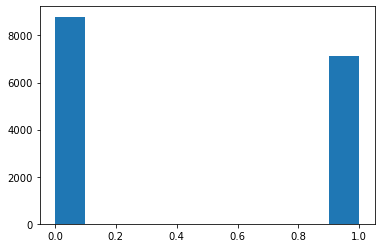

In [21]:
plt.hist(test_data_y)

In [22]:
8797/(8797+7128)

0.5524018838304553

## Traditional ML Model

In [29]:
from sklearn.ensemble import AdaBoostClassifier

In [19]:
train_x = train_data_x.reshape((71381, 24*256))
train_y = train_data_y.reshape((71381))

In [67]:
%%time
n_train = 5000
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(train_x[:n_train], train_y[:n_train])

CPU times: user 32min 5s, sys: 7.45 s, total: 32min 12s
Wall time: 32min 11s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=500, random_state=0)

In [68]:
train_pred = clf.predict(train_x[:n_train])
accu_train = sum(train_pred == train_y[:n_train]) / n_train
print(f'train acc = {accu_train}')

val_pred = clf.predict(val_data_x.reshape((39868, 24*256)))
val_y = val_data_y.reshape((39868))
accu_val = sum(val_pred == val_y) / len(val_y)
print(f'val acc = {accu_val}')

test_pred = clf.predict(test_data_x.reshape((15925, 24*256)))
test_y = test_data_y.reshape((15925))
accu_val = sum(test_pred == test_y) / len(test_y)
print(f'test acc = {accu_val}')

train acc = 0.9686
val acc = 0.6268435838266279
test acc = 0.5940973312401884


In [79]:
print(sum(train_y)/len(train_y))
print(sum(val_y)/len(val_y))
print(sum(test_y)/len(test_y))

0.389235230663622
0.3734323266780375
0.44759811616954476


In [69]:
from sklearn.tree import DecisionTreeClassifier

In [82]:
%%time
n_train = 10000
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(train_x[:n_train], train_y[:n_train])

CPU times: user 38.2 s, sys: 139 ms, total: 38.3 s
Wall time: 38.3 s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [83]:
train_pred = clf.predict(train_x[:n_train])
accu_train = sum(train_pred == train_y[:n_train]) / n_train
print(f'train acc = {accu_train}')

val_pred = clf.predict(val_data_x.reshape((39868, 24*256)))
val_y = val_data_y.reshape((39868))
accu_val = sum(val_pred == val_y) / len(val_y)
print(f'val acc = {accu_val}')

test_pred = clf.predict(test_data_x.reshape((15925, 24*256)))
test_y = test_data_y.reshape((15925))
accu_val = sum(test_pred == test_y) / len(test_y)
print(f'test acc = {accu_val}')

train acc = 0.6691
val acc = 0.6297782682853417
test acc = 0.6087912087912087


In [16]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
%%time
n_train = 10000
clf = RandomForestClassifier(n_estimators=200, min_samples_split=10, min_samples_leaf=5, random_state=0)
clf.fit(train_x[:n_train], train_y[:n_train])

CPU times: user 1min 54s, sys: 2.98 s, total: 1min 57s
Wall time: 1min 57s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [27]:
train_pred = clf.predict(train_x[:n_train])
accu_train = sum(train_pred == train_y[:n_train]) / n_train
print(f'train acc = {accu_train}')

val_pred = clf.predict(val_data_x.reshape((39868, 24*256)))
val_y = val_data_y.reshape((39868))
accu_val = sum(val_pred == val_y) / len(val_y)
print(f'val acc = {accu_val}')

test_pred = clf.predict(test_data_x.reshape((15925, 24*256)))
test_y = test_data_y.reshape((15925))
accu_val = sum(test_pred == test_y) / len(test_y)
print(f'test acc = {accu_val}')

train acc = 0.9903
val acc = 0.6881709641817999
test acc = 0.6462166405023548
